In [1]:
import gc
import glob
import os
import random
import re
import tarfile

import flash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torchvision
from PIL import Image
from tqdm import tqdm, trange

/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 2913
fix_seed(SEED)

In [3]:
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)
voc_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
voc_filename = "VOCtrainval_11-May-2012.tar"
if not os.path.exists(os.path.join(data_dir, voc_filename)):
    with open(os.path.join(data_dir, voc_filename), "wb") as f:
        res = requests.get(voc_url, stream=True)
        f.write(res.raw.read())
    tar_path = os.path.join(data_dir, voc_filename)
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(data_dir)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 3-1 セマンティックセグメンテーションとは？

セマンティックセグメンテーションとは、画像内の各ピクセルに対して、物体の分類を行うタスク。

以下のデータの可視化で詳細がわかるはず。

### ファイルの準備

In [5]:
img_paths = glob.glob(os.path.join(data_dir, "VOCdevkit/VOC2012/JPEGImages/*.jpg"))
len(img_paths)

17125

In [6]:
anno_paths = glob.glob(
    os.path.join(data_dir, "VOCdevkit/VOC2012/SegmentationClass/*.png")
)
len(anno_paths)

2913

In [7]:
with open(
    os.path.join(data_dir, "VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt")
) as f:
    train_ids = f.readlines()
with open(
    os.path.join(data_dir, "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt")
) as f:
    val_ids = f.readlines()
train_ids = [id_.strip() for id_ in train_ids]
val_ids = [id_.strip() for id_ in val_ids]
print(f"train_ids: {len(train_ids)}")
print(f"val_ids: {len(val_ids)}")

train_ids: 1464
val_ids: 1449


In [8]:
train_img_paths = [
    path for path in img_paths if os.path.basename(path).split(".")[0] in train_ids
]
train_img_paths = sorted(train_img_paths)
val_img_paths = [
    path for path in img_paths if os.path.basename(path).split(".")[0] in val_ids
]
val_img_paths = sorted(val_img_paths)
train_anno_paths = [
    path for path in anno_paths if os.path.basename(path).split(".")[0] in train_ids
]
train_anno_paths = sorted(train_anno_paths)
val_anno_paths = [
    path for path in anno_paths if os.path.basename(path).split(".")[0] in val_ids
]
val_anno_paths = sorted(val_anno_paths)

### データの確認

データを可視化して、Semantic Segmentationの理解を深める。

アノテーションのデータは、3チャネルではなく1チャネルであることに注意する。書く値に対応するクラスは[公式サイト](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html)に記載されている。

なお、255は"void or unlabelled"なので、0(background)にしておくのが良いだろう。

In [9]:
train_img_paths[0]

'../data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg'

In [10]:
train_anno_paths[0]

'../data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'

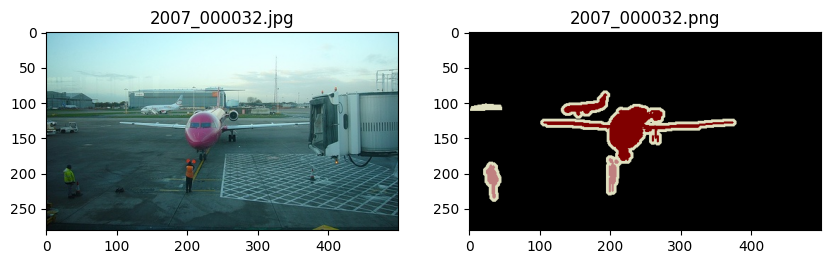

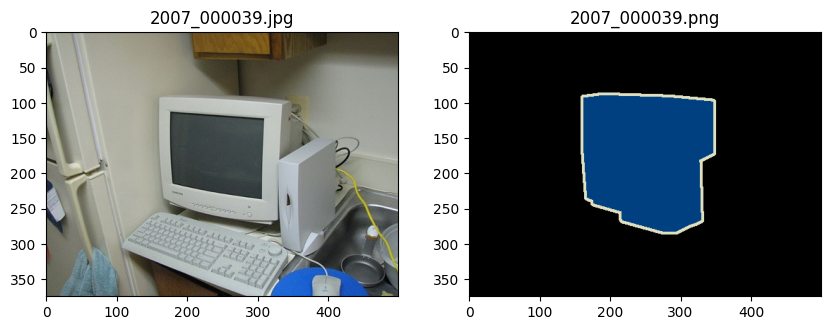

In [11]:
indices = [0, 1]
for index in indices:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(train_img_paths[index]))
    axes[0].set_title(os.path.basename(train_img_paths[index]))
    axes[1].imshow(Image.open(train_anno_paths[index]))
    axes[1].set_title(os.path.basename(train_anno_paths[index]))
    plt.show()

## 3-2 DataLoaderの作成

基本に忠実に作成すればいいが、DataTransformは書籍と発想が違うので注意。オリジナル画像とアノテーション画像を結合して、channelが4の画像として扱ってから、`torchvision.transform.*`の各関数を適用すれば、オリジナルと画像に対して同じ処理を施すことができて便利である。ただし、Normlaizeはアノテーションに適用してはいけないので注意。

以下の点に注意する。

- 先述した通り、255は0に変換する。

In [12]:
class VocSegDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, anno_paths, phase="train", transform=None):
        super().__init__()
        self.img_paths = img_paths
        self.anno_paths = anno_paths
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        self.phase = phase
        self.transform = transform
        if len(img_paths) != len(anno_paths):
            raise ValueError("The number of images and annotations must be the same.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        anno_path = self.anno_paths[idx]
        img = torchvision.io.read_image(img_path, mode=torchvision.io.ImageReadMode.RGB)
        anno = torchvision.io.read_image(
            anno_path, mode=torchvision.io.ImageReadMode.UNCHANGED
        )
        anno[anno == 255] = 0
        if self.transform:
            img, anno = self.transform(img, anno, phase=self.phase)
        anno.squeeze_(0)
        return img, anno

### DataTransformの実装

以下の点に注意して実装する。なお、書籍のようにPILやCV2を多用していると、何が何だかわからなくなるので、`torchvision.transforms`を極力使う方針とする。

- `torchvision.transforms`の関数を使いながら、画像とアノテーションに同じ処理を施したい。ただ、例えば`RandomResizedCrop`は、ランダムに処理が適用されるので注意が必要。ここで、画像とアノテーションを`concat`しておくと、画像とアノテーションに同じ処理を施せる。
- `torchvision.transforms.RandomRotation`では以下のように、回転後に邪魔な部分が残るので、`RandomRotationCrop`を独自に実装する。
- `RandomResizedCrop`は、`interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT`を引数に渡しておかないと、アノテーションが整数ではなくなってしまうので注意。`Resize`も同様。

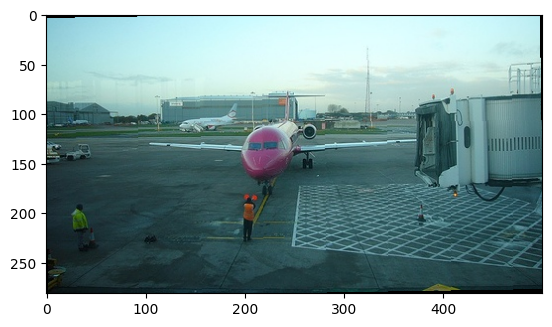

In [13]:
# RandomRotation will leave black areas around the image.
img = torchvision.io.read_image(
    train_img_paths[0], mode=torchvision.io.ImageReadMode.RGB
)
img = torchvision.transforms.RandomRotation(45)(img)
plt.imshow(img.permute(1, 2, 0))

In [14]:
import math


class RandomRotationCrop(torchvision.transforms.RandomRotation):
    """
    Randomly crop the image so that the rotated image does not include black pixels.
    Note: https://stackoverflow.com/questions/21346670/cropping-rotated-image-with-same-aspect-ratio
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.expand = False

    def rotatedRectWithMaxArea(self, w, h, angle):
        if w <= 0 or h <= 0:
            return 0, 0

        width_is_longer = w >= h
        side_long, side_short = (w, h) if width_is_longer else (h, w)

        # since the solutions for angle, -angle and 180-angle are all the same,
        # if suffices to look at the first quadrant and the absolute values of sin,cos:
        sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
        if side_short <= 2.0 * sin_a * cos_a * side_long or abs(sin_a - cos_a) < 1e-10:
            # half constrained case: two crop corners touch the longer side,
            #   the other two corners are on the mid-line parallel to the longer line
            x = 0.5 * side_short
            wr, hr = (
                (x / sin_a, x / cos_a) if width_is_longer else (x / cos_a, x / sin_a)
            )
        else:
            # fully constrained case: crop touches all 4 sides
            cos_2a = cos_a * cos_a - sin_a * sin_a
            wr, hr = (w * cos_a - h * sin_a) / cos_2a, (h * cos_a - w * sin_a) / cos_2a

        return wr, hr

    def forward(self, img):
        angle = self.get_params(self.degrees)
        angle_rad = math.radians(angle)
        if not 0 <= angle <= 90:
            raise ValueError("Angle must be 0 <= angle <= 90.")
        h, w = img.shape[1:]
        aspect_ratio = w / h
        img_rotated = torchvision.transforms.functional.rotate(
            img, angle, self.interpolation, self.expand, self.center, self.fill
        )
        h_crop = h / (aspect_ratio * math.sin(angle_rad) + math.cos(angle_rad))
        w_crop = h_crop * aspect_ratio
        return torchvision.transforms.functional.center_crop(
            img_rotated, (math.floor(h_crop), math.floor(w_crop))
        )

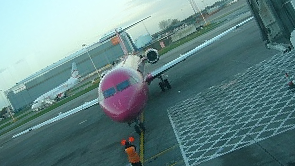

In [15]:
img = torchvision.io.read_image(
    train_img_paths[0], mode=torchvision.io.ImageReadMode.RGB
)
img = RandomRotationCrop((0, 45))(img)
display(torchvision.transforms.functional.to_pil_image(img))

In [16]:
class VocDataTransform:
    def __init__(self, input_size, color_mean, color_std):
        self.common_transform = {
            "train": torchvision.transforms.Compose(
                [
                    RandomRotationCrop((0, 45)),
                    torchvision.transforms.RandomResizedCrop(
                        input_size,
                        antialias=False,
                        interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                    ),
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.Resize(
                        (input_size, input_size),
                        antialias=False,
                        interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                    ),
                ]
            ),
            "val": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(
                        (input_size, input_size),
                        antialias=False,
                        interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                    ),
                ]
            ),
        }
        self.img_transform = {
            "train": torchvision.transforms.Compose(
                [
                    torchvision.transforms.ConvertImageDtype(torch.float32),
                    torchvision.transforms.Normalize(color_mean, color_std),
                ]
            ),
            "val": torchvision.transforms.Compose(
                [
                    torchvision.transforms.ConvertImageDtype(torch.float32),
                    torchvision.transforms.Normalize(color_mean, color_std),
                ]
            ),
        }

    def __call__(self, img, anno, phase="train"):
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        # img = torchvision.transforms.functional.to_tensor(img)
        # anno = torchvision.transforms.functional.to_tensor(anno)
        concat_img_anno = torch.cat([img, anno], dim=0)
        if phase not in ["train", "val"]:
            raise ValueError("phase must be 'train' or 'val'.")
        concat_img_anno = self.common_transform[phase](concat_img_anno)
        # img= self.common_transform[phase](img)
        # anno = self.common_transform[phase](anno)
        img = concat_img_anno[:3]
        anno = concat_img_anno[3:]
        img = self.img_transform[phase](img)
        return img, anno

VocDataTransformの確認

In [17]:
transform = VocDataTransform(457, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_dataset = VocSegDataset(
    train_img_paths, train_anno_paths, phase="train", transform=transform
)
val_dataset = VocSegDataset(
    val_img_paths, val_anno_paths, phase="val", transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


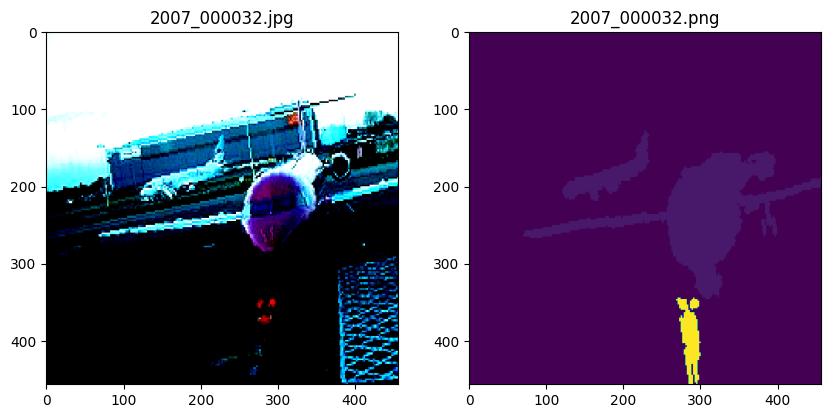

torch.Size([457, 457])

tensor([ 0,  1, 15], dtype=torch.uint8)

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
index = 0
img, anno = train_dataset[index]
axes[0].imshow(img.permute(1, 2, 0))
axes[0].set_title(os.path.basename(train_img_paths[index]))
axes[1].imshow(torchvision.transforms.functional.to_pil_image(anno))
axes[1].set_title(os.path.basename(train_anno_paths[index]))
plt.show()
display(anno.shape)
anno.unique()

In [19]:
# for simple test
batch_size = 8
assert batch_size >= 2  # for batch normalization

## 3-3 PSPNetのネットワーク構成と実装

```mermaid
flowchart LR; 
    img(img)
    E(Encoder)
    PP(Pyramid Pooling)
    D(Decoder)
    A(AuxLoss)
    output(output)
    output_a(output by AuxLoss)
    img --(3,475,475)-->E --(2048,60,60)-->PP--(4096,60,60)-->D--(21,475,475)-->output
    E--(1024,60,60)-->A-->output_a
```

AuxLossは学習時のみ使用され、推論時には使用されない。前半のEncoder部分で学習に失敗していると、後段での学習も当然失敗しているので、前半部分のロスを取り出すことで学習を効率化している、と自分は理解した。

## 3-4 Encoder(Feature)モジュール

```mermaid
flowchart LR;
    img(img)
    FeatureMapConv(FeatureMapConv)
    PSP1(ResidualBlockPSP)
    PSP2(ResidualBlockPSP)
    PSPd1("ResidualBlockPSP(dilated)")
    PSPd2("ResidualBlockPSP(dilated)")
    Decoder(Decoder)
    Aux(AuxLoss)

    img--(3,475,475)-->FeatureMapConv

    subgraph Encoder
        FeatureMapConv--(128,119,119)-->PSP1--(256,119,119)-->PSP2--(512,60,60)-->PSPd1--(1024,60,60)-->PSPd2
    end

    PSPd1 --(1024,60,60)--> Aux
    PSPd2 --(2048,60,60)--> Decoder
```

上記のネットワークを実装していく。なお、書籍のクラス名はPEPに沿っていなくて気持ち悪いので、適宜修正している。

Encoderの特徴として、チャネル数(dim=0)を増やすとともに、画像部分のサイズ(dim=1,2)を小さくしていることが挙げられる。
このようにすることで、画像全体に渡る大雑把な特徴量の多数の取得が期待できる。

#### 

#### FeatureMapConvの実装

```mermaid
flowchart LR;
    img(img)
    CBNR1(Conv2dBatchNormRelu)
    CBNR2(Conv2dBatchNormRelu)
    CBNR3(Conv2dBatchNormRelu)
    P(MaxPooling)

    img --(3,475,475)--> CBNR1
    subgraph FeatureMapConv
        CBNR1--(64,238,238)-->CBNR2--(64,238,238)-->CBNR3--(128,238,238)-->P
    end

    PSP(ResidualBlockPSP)
    P--(128,119,119)-->PSP
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    C3("Conv2d(kernel_size=3,stride=2,padding=1,dilation=1)")
    N(BatchNorm2d)
    R(ReLU)
    
    None1-->C3
    R-->None2
    subgraph Conv2dBatchNormRelu
        C3-->N-->R
    end
```

<e>バッチノーマライゼーション部分にはバイアス項が含まれるため、Conv2Dのバイアスを設定する必要がないことに注意。

In [20]:
class Conv2dBatchNorm(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            torch.nn.BatchNorm2d(out_channels),
        )

In [21]:
class Conv2dBatchNormReLU(Conv2dBatchNorm):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.add_module("ReLU", torch.nn.ReLU())

#### 

In [22]:
class FeatureMapConv(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            Conv2dBatchNormReLU(3, 64, 3, stride=2, padding=1, bias=False),
            Conv2dBatchNormReLU(64, 64, 3, stride=1, padding=1, bias=False),
            Conv2dBatchNormReLU(64, 128, 3, stride=1, padding=1, bias=False),
            torch.nn.AdaptiveMaxPool2d(119),
        )

In [23]:
input = torch.randn(batch_size, 3, 457, 457).to(device)
model = FeatureMapConv().to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 128, 119, 119])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 128, 119, 119])


### ResidualBlockPSP

```mermaid
flowchart LR;
    None1( )
    None2( )
    1(BottleNeckPSP)
    2(BottleNeckIdentifyPSP)
    3(BottleNeckPSP)
    None1-->1
    3-->None2
    subgraph ResidualBlockPSP
        1-->2-->3
    end
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    1("Conv2DBatchNormReLU, kernel_size=1")
    2("Conv2DBatchNormReLU, kernel_size=3")
    3("Conv2DBatchNorm, kernel_size=1")
    4("Conv2DBatchNorm, kernel_size=1")
    R(ReLU)

    None1-->1
    None1-->4
    R-->None2
    subgraph BottleNeckPSP
        1-->2-->3-->R
        4-->R
    end
```

```mermaid
flowchart LR;
    None1( )
    None2( )
    1("Conv2DBatchNormReLU, kernel_size=1")
    2("Conv2DBatchNormReLU, kernel_size=3")
    3("Conv2DBatchNorm, kernel_size=1")
    R(ReLU)

    None1-->1
    None1-->R
    R-->None2
    subgraph BottleNeckIdentifyPSP
        1-->2-->3-->R
    end
```

BottleNeckIdentifyPSPはスキップ結合を使用している。(BottleNeckPSPは部分的にスキップ結合していると言える？)

スキップ結合のメリットは以下。

- 全体で層が深い時でも勾配消失問題を避けることができる。
- 入力をx, 学習すべき出力をyとした時、スキップ結合があることに注意すると、モデルが学習するのはy-xになり、学習が楽になる。ネガティブフィードバックが働いていると考えるとわかりやすい気がする。

また、BottleNeckPSP, BottleNeckIdentifyPSPでは、kernel sizeが1の畳み込みが使用されている。これは1x1 convolutionと呼ばれ、以下の特徴を持つ。

- channel-wise fature learning, すなわち画素単位での特徴量の学習が可能になる。kernel sizeが1なので、これは当然。
- チャネル方向の次元削除。結局は全結合的な処理になっているが、空間の次元は削除しないまま、チャネルの次元を下げることにも使われる。

なお、BottleNeckPSP, BottleNeckIdentifyPSPにおいて、1,3段目のConv2dBatchNormでは、空間方向の次元は変化しない([ここ](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)の式から計算するとわかる)。よって、2段目部分の引数次第で次元が決まることになる。BottleNeckIdentifyPSPでは、入力と出力で、チャネルの次元を変化させない。

In [24]:
class BottleNeckPSP(torch.nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super().__init__()
        self.conv1 = Conv2dBatchNorm(
            in_channels, mid_channels, 1, stride=1, padding=0, dilation=1, bias=False
        )
        self.conv2 = Conv2dBatchNorm(
            mid_channels,
            mid_channels,
            3,
            stride=stride,
            padding=dilation,
            dilation=dilation,
            bias=False,
        )
        self.conv3 = Conv2dBatchNorm(
            mid_channels, out_channels, 1, stride=1, padding=0, dilation=1, bias=False
        )

        self.residual = Conv2dBatchNorm(
            in_channels,
            out_channels,
            1,
            stride=stride,
            padding=0,
            dilation=1,
            bias=False,
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.relu(h + self.residual(x))
        return h

In [25]:
class BottleNeckIdentifyPSP(torch.nn.Module):
    def __init__(self, in_channels, mid_channels, dilation):
        super().__init__()
        self.conv1 = Conv2dBatchNorm(
            in_channels, mid_channels, 1, stride=1, padding=0, dilation=1, bias=False
        )
        self.conv2 = Conv2dBatchNorm(
            mid_channels,
            mid_channels,
            3,
            stride=1,
            padding=dilation,
            dilation=dilation,
            bias=False,
        )
        self.conv3 = Conv2dBatchNorm(
            mid_channels, in_channels, 1, stride=1, padding=0, dilation=1, bias=False
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.relu(h + x)
        return h

In [26]:
class ResidualBlockPSP(torch.nn.Sequential):
    def __init__(
        self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation
    ):
        super().__init__()
        self.add_module(
            "block1",
            BottleNeckPSP(in_channels, mid_channels, out_channels, stride, dilation),
        )
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i + 2),
                BottleNeckIdentifyPSP(out_channels, mid_channels, dilation=dilation),
            )

簡易テスト

In [27]:
input = torch.randn(batch_size, 128, 119, 119).to(device)
model = ResidualBlockPSP(3, 128, 64, 256, stride=1, dilation=1).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 256, 119, 119])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 256, 119, 119])


In [28]:
input = torch.randn(batch_size, 256, 119, 119).to(device)
model = ResidualBlockPSP(4, 256, 128, 512, stride=2, dilation=1).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 512, 60, 60])
del input, model, output

torch.Size([8, 512, 60, 60])


In [29]:
input = torch.randn(batch_size, 512, 60, 60).to(device)
model = ResidualBlockPSP(6, 512, 256, 1024, stride=1, dilation=2).to(device)
output = model(input)
print(output.shape)
# assert output.shape == torch.Size([batch_size, 2048, 60, 60])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 1024, 60, 60])


In [30]:
input = torch.randn(batch_size, 1024, 60, 60).to(device)
model = ResidualBlockPSP(3, 1024, 512, 2048, stride=1, dilation=4).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 2048, 60, 60])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 2048, 60, 60])


In [31]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_conv = FeatureMapConv()
        self.res1 = ResidualBlockPSP(3, 128, 64, 256, stride=1, dilation=1)
        self.res2 = ResidualBlockPSP(4, 256, 128, 512, stride=2, dilation=1)
        self.res_d1 = ResidualBlockPSP(6, 512, 256, 1024, stride=1, dilation=2)
        self.res_d2 = ResidualBlockPSP(3, 1024, 512, 2048, stride=1, dilation=4)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.res1(x)
        x = self.res2(x)
        output_aux = self.res_d1(x)
        output = self.res_d2(output_aux)
        return output, output_aux

In [32]:
input = torch.randn(batch_size, 3, 457, 457).to(device)
model = Encoder().to(device)
output, output_aux = model(input)
print(output.shape)
print(output_aux.shape)
assert output.shape == torch.Size([batch_size, 2048, 60, 60])
assert output_aux.shape == torch.Size([batch_size, 1024, 60, 60])
del input, model, output, output_aux
torch.cuda.empty_cache()

torch.Size([8, 2048, 60, 60])
torch.Size([8, 1024, 60, 60])


## 3-5 Pyramid Poolingモジュールの実装

```mermaid
flowchart LR;
    input(input)
    output(output)
    c1(Conv2dBatchNormReLU)
    c2(Conv2dBatchNormReLU)
    c3(Conv2dBatchNormReLU)
    c6(Conv2dBatchNormReLU)
    i1(interpolate)
    i2(interpolate)
    i3(interpolate)
    i6(interpolate)
    p1(AdaptiveAvgPool2d)
    p2(AdaptiveAvgPool2d)
    p3(AdaptiveAvgPool2d)
    p6(AdaptiveAvgPool2d)

    input ----> p6 --(2048,6,6)--> c6 --(512,6,6)--> i6 --(512,60,60)--> output
    input ----> p3 --(2048,3,3)--> c3 --(512,3,3)--> i3 --(512,60,60)--> output
    input ----> p2 --(2048,2,2)--> c2 --(512,2,2)--> i2 --(512,60,60)--> output
    input ----> p1 --(2048,1,1)--> c1 --(512,1,1)--> i1 --(512,60,60)--> output
    input --(2048,60,60)--> output
```

セグメンテーション時には、色々なスケールで画像を確認することで精度の向上が期待できる。木をみて森を見ず、というイメージ。

そこで、AdaptiveAvgPool2dを使用することで、様々に画像をスケールし、それらを結合する。その際、空間の次元を揃えないといけないので、[interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html)を使用する。



In [33]:
class SinglePyramidPooling(torch.nn.Module):
    def __init__(self, in_channels, out_channels, pool_size):
        super().__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(pool_size)
        self.conv = Conv2dBatchNormReLU(
            in_channels, out_channels, 1, stride=1, padding=0, bias=False
        )

    def forward(self, x):
        height = x.size(2)
        width = x.size(3)
        h = self.avg_pool(x)
        h = self.conv(h)
        h = torch.nn.functional.interpolate(
            h, size=(height, width), mode="bilinear", align_corners=True
        )
        return h

In [34]:
input = torch.randn(batch_size, 2048, 60, 60).to(device)
model = SinglePyramidPooling(2048, 512, 6).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 512, 60, 60])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 512, 60, 60])


In [35]:
class PyramidPooling(torch.nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super().__init__()
        out_channels = int(in_channels / len(pool_sizes))
        self.pyramids = torch.nn.ModuleList(
            [
                SinglePyramidPooling(in_channels, out_channels, pool_size)
                for pool_size in pool_sizes
            ]
        )

    def forward(self, x):
        outputs = [x]
        for pyramid in self.pyramids:
            outputs.append(pyramid(x))
        return torch.cat(outputs, dim=1)

In [36]:
input = torch.randn(batch_size, 2048, 60, 60).to(device)
model = PyramidPooling(2048, [6, 3, 2, 1]).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 4096, 60, 60])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 4096, 60, 60])


## 3-6 Decoder, AuxLossモジュールの実装

```mermaid
flowchart LR;
    input(input)
    cb(Conv2dBatchNormReLU)
    d(Dropout)
    c(Conv2d)
    up(interpolate)
    none( )

    input --(4096,60,60)--> cb
    cb --(512,60,60)--> d --> c --(21,60,60)--> up --(21,475,475)--> none
```

最後にDecoderで、これまで抽出してきた特徴量を元画像と同じサイズにする。

AuxLossも、構造は全く同じ。

interpolateの前のサイズが(21,60,60)なので、この解像度が精度の限界になるのか？

In [37]:
class Decoder(torch.nn.Module):
    def __init__(self, in_channels, n_classes, output_size):
        super().__init__()
        self.output_size = output_size
        self.conv1 = Conv2dBatchNormReLU(
            in_channels, 512, 3, stride=1, padding=1, bias=False
        )
        self.dropout = torch.nn.Dropout2d(p=0.1)
        self.conv2 = torch.nn.Conv2d(512, n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = torch.nn.functional.interpolate(
            x, size=self.output_size, mode="bilinear", align_corners=True
        )
        return x

In [38]:
input = torch.randn(batch_size, 4096, 60, 60).to(device)
model = Decoder(4096, 21, (457, 457)).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 21, 457, 457])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 21, 457, 457])


In [39]:
class AuxLoss(torch.nn.Module):
    def __init__(self, in_channels, n_classes, output_size):
        super().__init__()
        self.output_size = output_size
        self.conv1 = Conv2dBatchNormReLU(
            in_channels, 256, 3, stride=1, padding=1, bias=False
        )
        self.dropout = torch.nn.Dropout2d(p=0.1)
        self.conv2 = torch.nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = torch.nn.functional.interpolate(
            x, size=self.output_size, mode="bilinear", align_corners=True
        )
        return x

In [40]:
input = torch.randn(batch_size, 1024, 60, 60).to(device)
model = AuxLoss(1024, 21, (457, 457)).to(device)
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 21, 457, 457])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 21, 457, 457])


### PSPモデルの作成

これまで作成してきたモデルを組み合わせて、最終的な`PspNet`を作成する。

evalの時は`aux_output`は不要。よって、よって、推論時のみ、`aux_output`も出力するようにする。

In [41]:
class PspNet(torch.nn.Module):
    def __init__(self, n_classes=21):
        super().__init__()
        self.encoder = Encoder()
        self.pyramid_pooling = PyramidPooling(2048, [6, 3, 2, 1])
        self.decoder = Decoder(4096, n_classes, (457, 457))
        self.aux = AuxLoss(1024, n_classes, (457, 457))

    def forward(self, x):
        x, aux_loss = self.encoder(x)
        x = self.pyramid_pooling(x)
        output = self.decoder(x)
        if self.training:
            aux_output = self.aux(aux_loss)
            return output, aux_output
        else:
            return output

In [42]:
# simple test for training
input = torch.randn(batch_size, 3, 457, 457).to(device)
model = PspNet(n_classes=21).to(device)
model.train()
output, aux_output = model(input)
print(output.shape)
print(aux_output.shape)
assert output.shape == torch.Size([batch_size, 21, 457, 457])
assert aux_output.shape == torch.Size([batch_size, 21, 457, 457])
del input, model, output, aux_output
torch.cuda.empty_cache()

torch.Size([8, 21, 457, 457])
torch.Size([8, 21, 457, 457])


In [43]:
# simple test for inference
input = torch.randn(batch_size, 3, 457, 457).to(device)
model = PspNet(n_classes=21).to(device)
model.eval()
output = model(input)
print(output.shape)
assert output.shape == torch.Size([batch_size, 21, 457, 457])
del input, model, output
torch.cuda.empty_cache()

torch.Size([8, 21, 457, 457])


## 3-7 学習と検証の実施

ここでは、ファインチューニングは行わず、初期から学習する。

ここでは、[PyTorchでの学習・推論を高速化するコツ集](https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587)を参考に、学習を高速化する。ただし、記事の執筆時点から時間が経っているほか、利便性などを考慮して以下の点を変更する。

- apexのインストールは面倒なので(というか自分は躓いたので)、apexを使用しない方法で実装する。
- 幸い、apexのampはdeprecatedになっており、Pytorchに[実装](https://pytorch.org/docs/stable/amp.html)があるので、そちらを使用する。AMPは[こちら](https://qiita.com/bowdbeg/items/71c62cf8ef891d164ecd)を参考にした。
- LAMBはlightning flashの[実装](https://lightning-flash.readthedocs.io/en/stable/api/generated/flash.core.optimizers.LAMB.html)を使用する。

### そのほか注意点

- optimizerの学習率を大きくしすぎると、出力がnanになって学習がうまくいかなくなる。デバッグ用に、出力がnanになった時はその点をprintするようにしている。(遅くなるので、うまくいきそうであればコメントアウト)

In [44]:
batch_size = 8
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
phase2data_loader = {"train": train_data_loader, "val": val_data_loader}

In [45]:
model = PspNet(n_classes=21).to(device)
optimizer = flash.core.optimizers.LAMB(model.parameters(), lr=0.001)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
scaler = torch.cuda.amp.GradScaler()

# initialize model's weights
for param in model.parameters():
    torch.nn.init.normal_(param, mean=0.0, std=0.1)

num_epochs = 100

In [46]:
weigh_save_path = "weights"
os.makedirs(weigh_save_path, exist_ok=True)
exising_weights = glob.glob(os.path.join(weigh_save_path, "*.pth"))
done_epochs = [int(re.search(r"epoch(\d+)", path).group(1)) for path in exising_weights]
done_epochs = sorted(done_epochs)
skip_done_epochs = True

In [47]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [48]:
for idx_epoch in range(num_epochs):
    start.record()
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    if skip_done_epochs and done_epochs and idx_epoch + 1 <= done_epochs[-1]:
        if idx_epoch + 1 == done_epochs[-1]:
            checkpoint = torch.load(
                os.path.join(weigh_save_path, f"pspnet_epoch{idx_epoch + 1}.pth"),
                map_location=device,
            )
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            scaler.load_state_dict(checkpoint["scaler_state_dict"])
        continue
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            if (idx_epoch + 1) % 10 != 0:
                continue
            model.eval()

        for idx_batch, (imgs, annos) in enumerate(phase2data_loader[phase]):
            imgs = imgs.to(device, non_blocking=True)
            annos = annos.to(device, non_blocking=True).long()
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                if phase == "train":
                    if imgs.size(0) == 1:
                        continue
                    with torch.cuda.amp.autocast(dtype=torch.float16):
                        outputs, aux_outputs = model(imgs)
                        loss = torch.nn.functional.cross_entropy(
                            outputs, annos, reduction="mean"
                        ) + 0.4 * torch.nn.functional.cross_entropy(
                            aux_outputs, annos, reduction="mean"
                        )
                    scaler.scale(loss).backward()
                    epoch_train_loss += (
                        loss.item()
                        * imgs.size(0)
                        / len(phase2data_loader[phase].dataset)
                    )
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(imgs)
                    loss = torch.nn.functional.cross_entropy(outputs, annos)
                    epoch_val_loss += (
                        loss.item()
                        * imgs.size(0)
                        / len(phase2data_loader[phase].dataset)
                    )

    if (idx_epoch + 1) % 10 == 0:
        torch.save(
            {
                "epoch": idx_epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                "train_loss": epoch_train_loss,
                "val_loss": epoch_val_loss if (idx_epoch + 1) % 10 == 0 else None,
            },
            os.path.join(weigh_save_path, f"pspnet_epoch{idx_epoch + 1}.pth"),
        )

    # save train_loss and val_loss as csv
    with open(os.path.join(weigh_save_path, "loss.csv"), "a") as f:
        f.write(f"{idx_epoch + 1},{epoch_train_loss},{epoch_val_loss}\n")

    end.record()
    torch.cuda.synchronize()
    elapsed_time = start.elapsed_time(end) / 1000
    print(
        f"epoch: {idx_epoch + 1}, eslapsed_time: {elapsed_time:.2f}, train_loss: {epoch_train_loss:.2f}, val_loss: {epoch_val_loss:.2f}"
    )

## 3-7 推論結果の確認

このNotebookでは、転移学習をせずに、VOCのデータのみを用いて学習を行った。100エポック後の結果を下に示す。

学習が全くできていないというわけではなさそうだが、制度は明らかによろしくない。VOCのデータセットだけでは厳しかったのだろうか、、、

In [49]:
done_epochs = [int(re.search(r"epoch(\d+)", path).group(1)) for path in exising_weights]
done_epochs = sorted(done_epochs)
checkpoint = torch.load(
    os.path.join(weigh_save_path, "pspnet_epoch{}.pth".format(done_epochs[-1])),
    map_location=device,
)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scaler.load_state_dict(checkpoint["scaler_state_dict"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


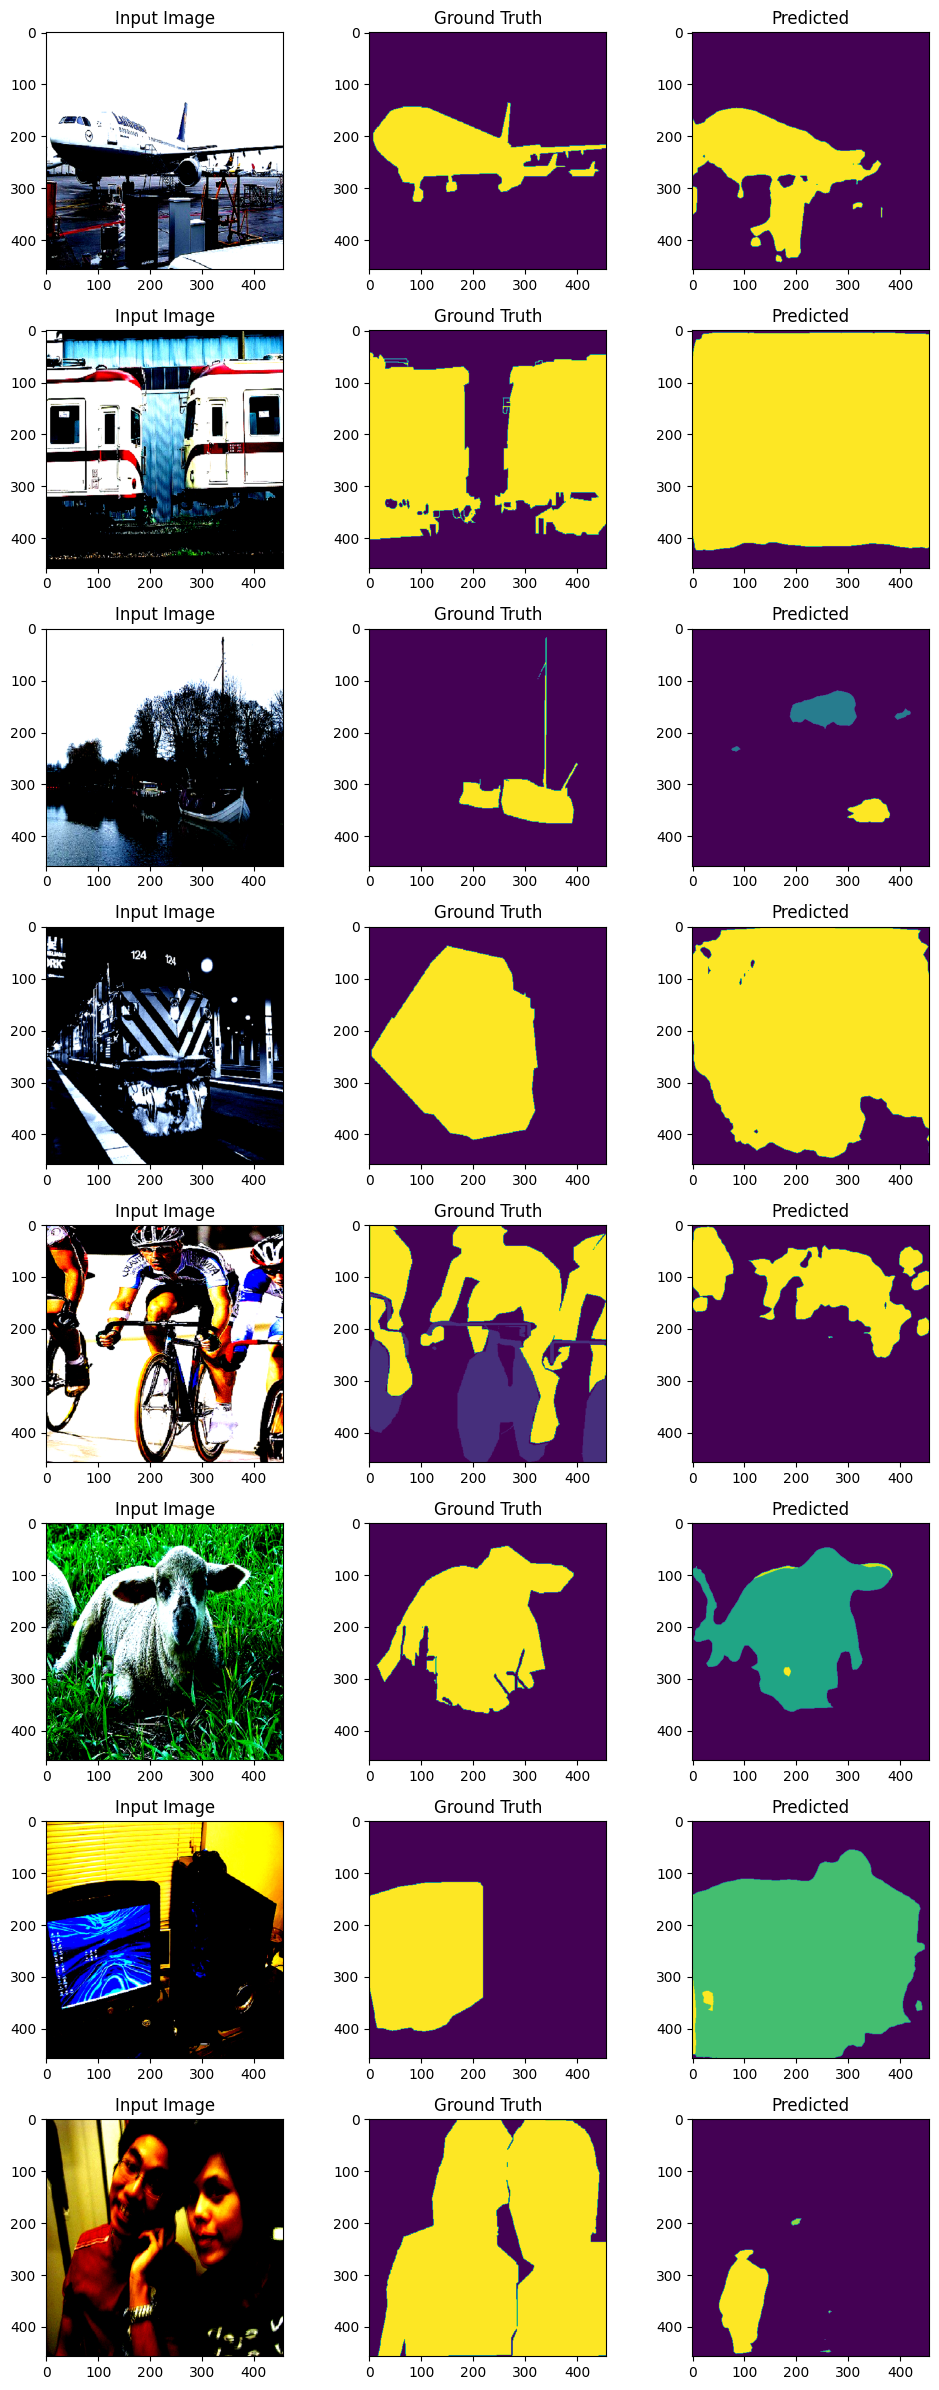

In [50]:
model.eval()
for val_imgs, val_annos in val_data_loader:
    val_imgs = val_imgs.to(device)
    val_annos = val_annos.to(device).long()
    fig, axes = plt.subplots(batch_size, 3, figsize=(10, 3 * batch_size))
    with torch.no_grad():
        val_outputs = model(val_imgs)
    for idx in range(batch_size):
        axes[idx][0].imshow(val_imgs[idx].permute(1, 2, 0).cpu())
        axes[idx][0].set_title("Input Image")
        axes[idx][1].imshow(val_annos[idx].cpu())
        axes[idx][1].set_title("Ground Truth")
        axes[idx][2].imshow(val_outputs.argmax(dim=1).cpu()[idx])
        axes[idx][2].set_title("Predicted")
    plt.tight_layout()
    plt.show()
    break

Text(0, 0.5, 'loss')

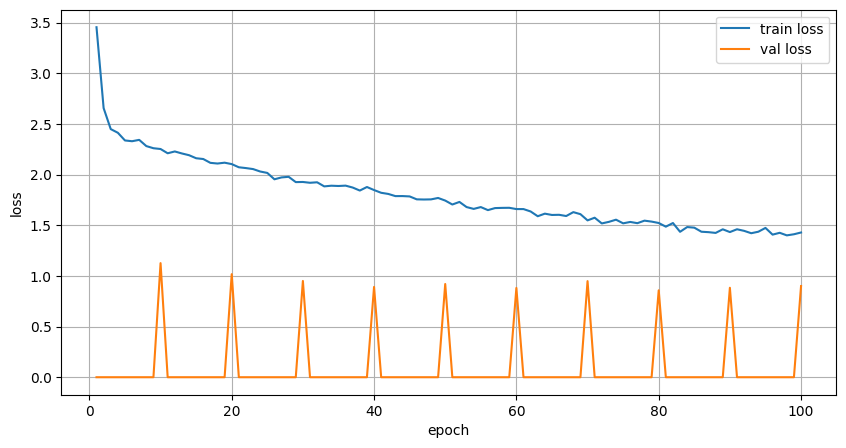

In [51]:
# plot val loss and train loss
losses = pd.read_csv(
    os.path.join(weigh_save_path, "loss.csv"),
    header=None,
    names=["epoch", "train_loss", "val_loss"],
)
# drop duplicates in epoch
losses = losses.drop_duplicates(subset="epoch")
torch.cuda.empty_cache()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(losses["epoch"], losses["train_loss"], label="train loss")
ax.plot(losses["epoch"], losses["val_loss"], label="val loss")
ax.legend()
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")